<a href="https://colab.research.google.com/github/shahriarivari/Load-Forecasting-Machine-Learing/blob/main/load_forecasting_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# installing libraries

In [1]:
# installing jdatetime for converting date to Gregotian
# !pip install scikit-learn
# !pip install matplotlib
!pip install jdatetime
!pip install scikit-optimize
!pip install bayesian-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.9 MB/s eta 0:00:00


# data manipulation

inculding: 1-becoming one with data, 2-feature engieering, and 3-preprocessing

In [2]:
import pandas as pd # to import the excel file
import numpy as np  # to deal with numbers
import jdatetime    # to convert Jalali datatime to Gregorian

In [3]:
## importing data files
data_df = pd.read_excel("consumption.xlsx") # includes each day in a row with hours of the day as columns
temp_df = pd.read_csv("temperature.csv") # includes the temprature of eaach day

In [4]:
# adding another column "time" which are the dates in Gregorian format and then removing the "date" column
# Apply the conversion directly using a lambda function
data_df['time'] = data_df['date'].apply(lambda x: jdatetime.datetime.strptime(x, '%Y/%m/%d').togregorian().strftime('%Y-%m-%d'))
data_df.drop(columns="date",axis = 1, inplace=True)

In [5]:
# making the dataframe into a column vector of time and power consumption
# we make to lists of hours and their repective values and then concatenate them
time_hourly = []
values_hourly = []
list_of_hours = np.arange(1,25)
for i in range(len(data_df["time"])):
    time = pd.to_datetime(data_df['time'][i], format='%Y-%m-%d') + pd.to_timedelta(list_of_hours, unit='h').values
    values = data_df.loc[i][:-1].values
    time_hourly.append(time)
    values_hourly.append(values)

In [6]:
time_concatenated = np.concatenate(time_hourly)
values_concatenated = np.concatenate(values_hourly)

In [7]:
# and now we make the new df
new_df = pd.DataFrame({"time": time_concatenated, "power": values_concatenated})
print(f" changed the data frame from {data_df.shape} to {new_df.shape} ")

 changed the data frame from (730, 25) to (17520, 2) 


In [8]:
# adding another column to the new_df, which is the temperature of each hour using the temp_df
temp_df["time"] = pd.to_datetime(temp_df['time'], format='%Y-%m-%d') # changing the format to pd.datetime
# Concatenate based on the 'Time' column
concat_df = pd.concat([new_df.set_index('time'), temp_df.set_index('time')], axis=1, join='inner')
# Reset the index to make 'Time' a column again
concat_df.reset_index(inplace=True)
concat_df.head(2)

,time,power,temp
0,2021-03-21 01:00:00,683.189471,6.7
1,2021-03-21 02:00:00,627.645948,6.1


### adding features to the dataset
up untill now we've made a new data frame with "time" indicating each day and hour with its respective "power" and "temp".
Now we try addind new features based on the information we have, to feed it to our model

In [9]:
# addding mutiple columns using the "time" col
concat_df["week_day"] = concat_df["time"].dt.weekday
concat_df["day"] = concat_df["time"].dt.day
concat_df['month'] = concat_df["time"].dt.month
concat_df["hour"] = concat_df["time"].dt.hour

# extracting features
concat_df['up_of_month']=(concat_df['day']<=10).astype(int)
concat_df['down_of_month']=(concat_df['day']>20).astype(int)
concat_df['sin_day']=np.sin(2*np.pi*concat_df['day']/30)
concat_df['cos_day']=np.cos(2*np.pi*concat_df['day']/30)

concat_df['morning']=((concat_df['hour']>5)&(concat_df['hour']<=12)).astype(int)
concat_df['afternoon']=((concat_df['hour']>12)&(concat_df['hour']<=19)).astype(int)
concat_df['evening']=(1-concat_df['morning']-concat_df['afternoon']).astype(int)

#  whether its thursday | friday or not
concat_df['weekend'] = ((concat_df["week_day"] == 4) | (concat_df["week_day"] == 3)).astype(int)
concat_df['time_slot'] = pd.cut(concat_df["hour"], bins=[0, 6, 12, 18, 24], labels=[1, 2, 3, 4], right=False)
concat_df['peak_load'] = ((concat_df["hour"] >= 11) & (concat_df["hour"] <= 15)).astype(int)

concat_df['spring']=((concat_df['month']>=3)&(concat_df['month']<=5)).astype(int)
concat_df['summer']=((concat_df['month']>=6)&(concat_df['month']<=8)).astype(int)
concat_df['fall']=((concat_df['month']>=9)&(concat_df['month']<=11)).astype(int)
concat_df['winter']=((concat_df['month']==12)&(concat_df['month']<=2)).astype(int)

# adding the mean of the past 4 "values" for each row
previous_four_mean = np.array(concat_df["power"][0:4].values).astype(np.float32)
for i in range(4,len(concat_df)):
  previous_four_mean = np.append(previous_four_mean, concat_df["power"][i-4:i].values.mean()).astype(np.float32)
concat_df["four_mean"] = previous_four_mean

# dropping non-informative columns
concat_df.drop( ["day", "week_day", "month","hour"] , axis = 1, inplace = True)

In [10]:
print(f"number of features: {len(concat_df.columns)}, including the 'time' column\n columns are :\n{concat_df.columns.values}")

number of features: 18, including the 'time' column
 columns are :
['time' 'power' 'temp' 'up_of_month' 'down_of_month' 'sin_day' 'cos_day'
 'morning' 'afternoon' 'evening' 'weekend' 'time_slot' 'peak_load'
 'spring' 'summer' 'fall' 'winter' 'four_mean']


### plotting to get some information
plotting the "power" with respect to temperatue and time to see the relation between them


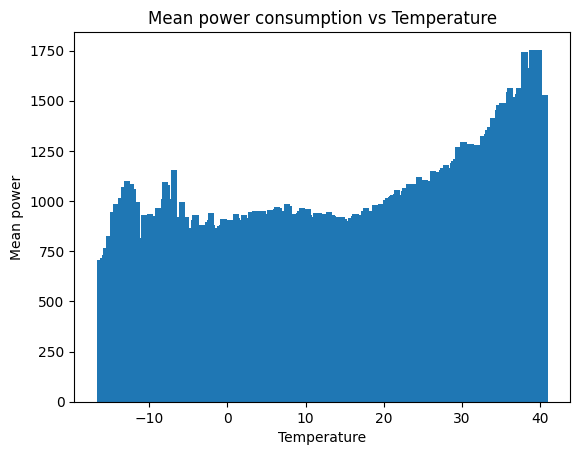

In [11]:
# plotting temperatue vs power consumption
import matplotlib.pyplot as plt
unique_temps = np.unique(concat_df['temp'])
# Plotting
plt.bar(unique_temps, concat_df.groupby('temp')['power'].mean())
plt.xlabel('Temperature')
plt.ylabel('Mean power')
plt.title('Mean power consumption vs Temperature')
plt.show()

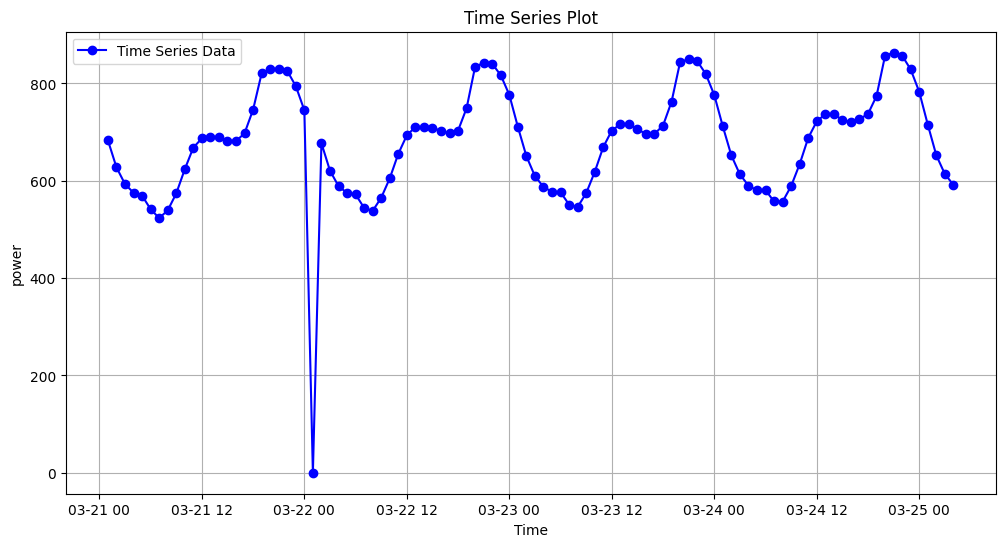

In [12]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(concat_df['time'][:100], concat_df['power'][:100], label='Time Series Data', marker='o', linestyle='-', color='b')
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('power')
plt.legend()
plt.grid(True)
plt.show()

### Normalizing using the Standard Deviation Normalization method

In [13]:
# normalizing the value and mean columns
# Normalizing using the Standard Deviation Normalization method
concat_df_value_mean = concat_df["power"].mean()
concat_df_value_std = concat_df["power"].std()
concat_df.loc[:, "power"] = (concat_df["power"] - concat_df_value_mean) / concat_df_value_std

concat_df_four_mean_mean = concat_df["four_mean"].mean()
concat_df_four_mean_std = concat_df["four_mean"].std()
concat_df.loc[:, "four_mean"] = (concat_df["four_mean"] - concat_df_four_mean_mean) / concat_df_four_mean_std

# changed the "values" columns dtype to float
concat_df["power"] = pd.to_numeric(concat_df['power'], errors='coerce').astype(float)

In [14]:
# adding 3 more features, which are the values of three previous hours
concat_df['one_hour_ago'] = concat_df['power'].shift(1)
concat_df['two_hours_ago'] = concat_df['power'].shift(2)
concat_df['three_hours_ago'] = concat_df['power'].shift(3)
columns_to_fill = ['one_hour_ago', 'two_hours_ago', 'three_hours_ago']
concat_df[columns_to_fill] = concat_df[columns_to_fill].fillna(method='bfill')

# Lightgbm Model
For our first model we are going to use Gradient Boosting Models using the "lightgbm" framework which uses tree based learning algorithms.


In [ ]:
from sklearn.model_selection import KFold #Import the k-fold cross validation function in the machine learning library
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import lightgbm as lgb

## hyper parametere tuning

In [ ]:
# Drop any other columns that are not features or the target variable
features = concat_df.drop(columns=['power','time'],axis =1)
target = concat_df['power']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42)

# Define the objective function for Bayesian Optimization
def lgbm_cv(num_leaves, learning_rate, n_estimators, feature_fraction, bagging_fraction, bagging_freq, min_child_samples):
    params = {
        'objective': 'regression',
        'num_leaves': int(num_leaves),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'feature_fraction': max(min(feature_fraction, 1), 0),
        'bagging_fraction': max(min(bagging_fraction, 1), 0),
        'bagging_freq': int(bagging_freq),
        'min_child_samples': int(min_child_samples),
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt'
    }

    # Perform K-Fold cross-validation on the training set
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train_kf, y_train_kf)

        # Predict on the validation set and calculate RMSE
        y_pred = model.predict(X_val_kf)
        rmse = np.sqrt(mean_squared_error(y_val_kf, y_pred))
        rmse_scores.append(rmse)

    # Return the average RMSE across folds
    return -np.mean(rmse_scores)

# Define the parameter space for Bayesian Optimization
pbounds = {
    'num_leaves': (5, 50),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 200),
    'feature_fraction': (0.1, 0.9),
    'bagging_fraction': (0.1, 0.9),
    'bagging_freq': (1, 10),
    'min_child_samples': (5, 30)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=lgbm_cv,
    pbounds=pbounds,
    random_state=42,
)

# Run Bayesian Optimization
optimizer.maximize(init_points=10, n_iter=30)

# Get the best hyperparameters
best_params = optimizer.max['params']
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['bagging_freq'] = int(best_params['bagging_freq'])
best_params['min_child_samples'] = int(best_params['min_child_samples'])

|   iter    |  target   | baggin... | baggin... | featur... | learni... | min_ch... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------
| 1         | -0.1488   | 0.3996    | 9.556     | 0.6856    | 0.1836    | 8.9       | 73.4      | 7.614     |
| 2         | -0.1848   | 0.7929    | 6.41      | 0.6665    | 0.01597   | 29.25     | 174.9     | 14.56     |
| 3         | -0.155    | 0.2455    | 2.651     | 0.3434    | 0.1622    | 15.8      | 93.68     | 32.53     |
| 4         | -0.1434   | 0.2116    | 3.629     | 0.3931    | 0.1423    | 24.63     | 79.95     | 28.14     |
| 5         | -0.1192   | 0.5739    | 1.418     | 0.586     | 0.05945   | 6.626     | 192.3     | 48.45     |
| 6         | -0.1771   | 0.7467    | 3.742     | 0.1781    | 0.2084    | 16.0      | 68.31     | 27.28     |
| 7         | -0.1631   | 0.1275    | 9.184     | 0.307     | 0.2021    | 12.79     | 128.0     | 29.6      |
| 8       

In [ ]:
best_params

{'bagging_fraction': 0.8188551143161308,
 'bagging_freq': 6,
 'feature_fraction': 0.9,
 'learning_rate': 0.3,
 'min_child_samples': 30,
 'n_estimators': 99,
 'num_leaves': 39}

## training phase
train the model using the "best_params"

In [ ]:
# Train the final model with the best hyperparameters using the entire training set
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X_train, y_train)

# Evaluate the final model on the test set
y_pred_test = final_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Final model RMSE on the test set: {rmse_test}")

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8188551143161308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8188551143161308
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8188551143161308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8188551143161308
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

## plotting the results
plotting the actual values and preicted ones for both training and testing data

In [ ]:
actual_train_values = concat_df.loc[X_train.index, ['time','power']].sort_index()
actual_train_values['predicted_power'] = final_model.predict(X_train.sort_index())
print(actual_train_values.head())
rmse_train = np.sqrt(mean_squared_error(actual_train_values['power'], actual_train_values['predicted_power']))
print(f"Final model RMSE on the train set: {rmse_train}")

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8188551143161308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8188551143161308
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
                 time     power  predicted_power
0 2021-03-21 01:00:00 -1.450911        -1.456326
1 2021-03-21 02:00:00 -1.712721        -1.465997
2 2021-03-21 03:00:00 -1.874550        -1.705061
4 2021-03-21 05:00:00 -1.986965        -1.893530
5 2021-03-21 06:00:00 -2.118310        -1.953319
Final model RMSE on the train set: 0.07878995259259435


In [ ]:
actual_test_values = concat_df.loc[X_test.index, ['time','power']].sort_index()
actual_test_values['predicted_power'] = final_model.predict(X_test.sort_index())
print(actual_train_values.head())
rmse_test = np.sqrt(mean_squared_error(actual_test_values['power'], actual_test_values['predicted_power']))
print(f"Final model RMSE on the test set: {rmse_test}")

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8188551143161308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8188551143161308
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
                 time     power  predicted_power
0 2021-03-21 01:00:00 -1.450911        -1.456326
1 2021-03-21 02:00:00 -1.712721        -1.465997
2 2021-03-21 03:00:00 -1.874550        -1.705061
4 2021-03-21 05:00:00 -1.986965        -1.893530
5 2021-03-21 06:00:00 -2.118310        -1.953319
Final model RMSE on the test set: 0.08832614977331713


### denormalization stage

In [ ]:
actual_train_values['power'] = (actual_train_values['power']*concat_df_value_std) +concat_df_value_mean
actual_train_values['predicted_power'] = (actual_train_values['predicted_power']*concat_df_value_std) +concat_df_value_mean

actual_test_values['power'] = (actual_test_values['power']*concat_df_value_std) +concat_df_value_mean
actual_test_values['predicted_power'] = (actual_test_values['predicted_power']*concat_df_value_std) +concat_df_value_mean

### plots

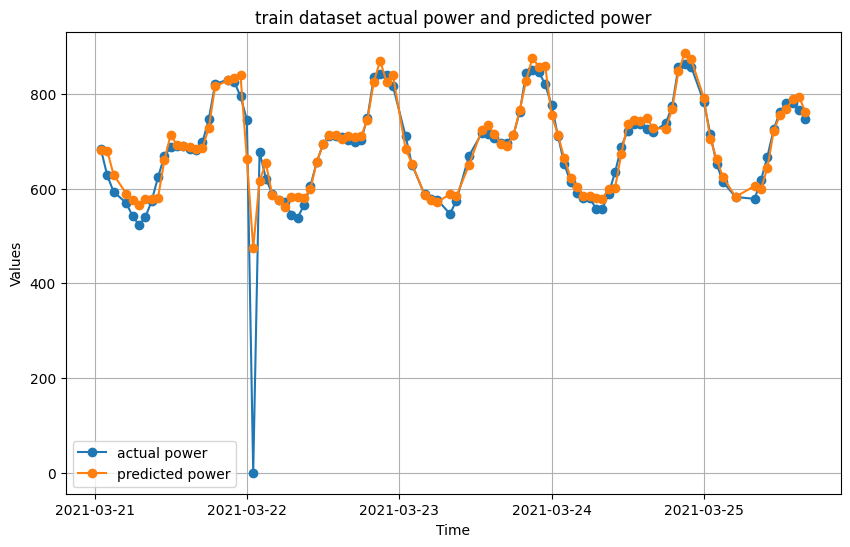

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))

# Plotting Value1 against Time
plt.plot(actual_train_values['time'][:100], actual_train_values['power'][:100], label='actual power', marker='o', linestyle='-')

# Plotting Value2 against Time
plt.plot(actual_train_values['time'][:100], actual_train_values['predicted_power'][:100], label='predicted power', marker='o', linestyle='-')

plt.title('train dataset actual power and predicted power')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

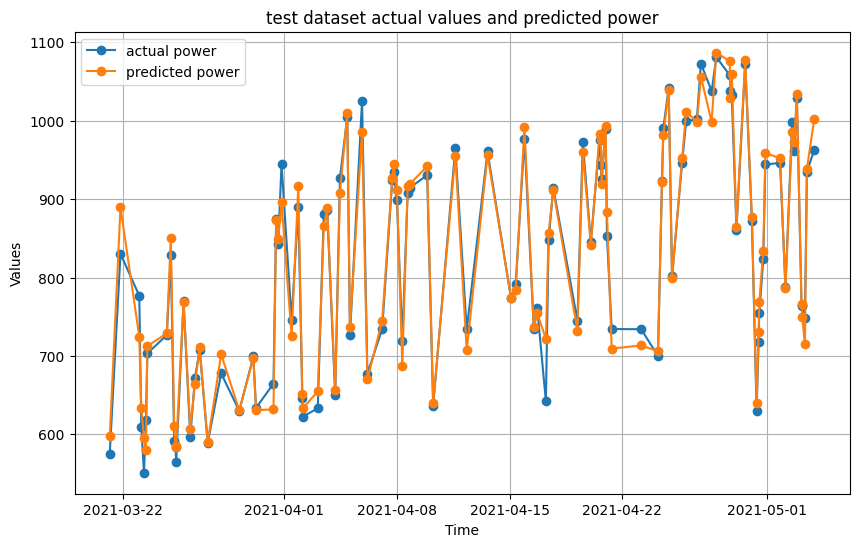

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))

# Plotting Value1 against Time
plt.plot(actual_test_values['time'][:100], actual_test_values['power'][:100], label='actual power', marker='o', linestyle='-')

# Plotting Value2 against Time
plt.plot(actual_test_values['time'][:100], actual_test_values['predicted_power'][:100], label='predicted power', marker='o', linestyle='-')

plt.title('test dataset actual values and predicted power')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

# Neural Network model
developing a simple MLP for regression task using Pytorch framework

In [ ]:
# Standard PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## train-test split

In [ ]:
# convert the data to a PyTorch tensor
X = torch.tensor(concat_df.drop(columns=['power','time'],axis =1).values, dtype=torch.float32)
y = torch.tensor(concat_df["power"].values, dtype=torch.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Convert data to PyTorch DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

## constructing the model

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size:int, num_hidden_units:int, num_layers:int):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_size, num_hidden_units))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(num_hidden_units, num_hidden_units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=0.2))
        layers.append(nn.Linear(num_hidden_units, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## building train and evaluation loop function

In [ ]:
# Function to train and evaluate the model
def train_and_evaluate(model, train_loader, test_data, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):

        ### Training
        train_loss = 0
        for inputs, labels in train_loader:

            model.train()

            outputs = model(inputs.to(device))

            loss = criterion(outputs, labels.view(-1, 1).to(device))
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        # Divide total train loss by length of train dataloader (average loss per batch per epoch)
        train_loss /= len(train_loader)

        # Evaluate the model on the test set
        model.eval()
        with torch.inference_mode():
            test_inputs, test_labels = test_data
            predictions = model(test_inputs.to(device))
            test_loss = criterion(predictions, test_labels.to(device).view(-1, 1))

        ## Print out what's happening
        if (epoch+1) % 10 == 0:
            print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Epoch: {epoch+1}")


   #return train_loss , test_loss

## Grid-search hyper-parameter tuning

In [ ]:
# Grid search hyperparameter tuning
param_grid = {
    'num_hidden_units': [16, 32],
    'num_layers': [2, 3,4],
    'learning_rate': [0.001, 0.01, 0.1]
}

In [ ]:
best_model = None
best_params = None
best_loss = float('inf')

In [ ]:
# for loop to search the parameter space for the best parameters
# Convert test data to PyTorch tensor
test_data = (X_test.to(device), y_test.to(device))
counter = 1
for params in ParameterGrid(param_grid):

    print(f"{counter} set of params in total {len(ParameterGrid(param_grid))}")
    learning_rate = params['learning_rate']
    del params['learning_rate']  # Remove learning_rate from params

    model = NeuralNetwork(input_size=X.shape[1], **params).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_and_evaluate(model, train_loader, test_data, criterion, optimizer, num_epochs = 5)

    # Evaluate the model on the test set and update the best model if needed
    model.eval()
    with torch.inference_mode():
        predictions = model(X_test.to(device))
        test_loss = mean_squared_error(predictions.numpy(), y_test.numpy())
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model
            best_params = params
            best_learning_rate = learning_rate
    counter +=1

print("Best Hyperparameters:", best_params)
print("Best Test Loss:", best_loss)
print("Best Learning Rate:", best_learning_rate)

1 set of params in total 18
2 set of params in total 18
3 set of params in total 18
4 set of params in total 18
5 set of params in total 18
6 set of params in total 18
7 set of params in total 18
8 set of params in total 18
9 set of params in total 18
10 set of params in total 18
11 set of params in total 18
12 set of params in total 18
13 set of params in total 18
14 set of params in total 18
15 set of params in total 18
16 set of params in total 18
17 set of params in total 18
18 set of params in total 18
Best Hyperparameters: {'num_hidden_units': 32, 'num_layers': 2}
Best Test Loss: 0.014478649
Best Learning Rate: 0.001


## training model using the grid search hyper-parameter method

In [ ]:
# Train the best model on the entire dataset
best_model = NeuralNetwork(input_size=X.shape[1], **best_params)
optimizer = optim.Adam(best_model.parameters(), lr=best_learning_rate)
train_and_evaluate(best_model.to(device),
                   DataLoader(TensorDataset(X.to(device), y.to(device)), batch_size=32, shuffle=True),
                   (X_test.to(device), y_test.to(device)),
                   nn.MSELoss(),
                   optimizer, num_epochs=100)

Train loss: 0.03726 | Test loss: 0.01321, Epoch: 10
Train loss: 0.03337 | Test loss: 0.01595, Epoch: 20
Train loss: 0.03151 | Test loss: 0.01060, Epoch: 30
Train loss: 0.03000 | Test loss: 0.01138, Epoch: 40
Train loss: 0.02996 | Test loss: 0.00949, Epoch: 50
Train loss: 0.03054 | Test loss: 0.00941, Epoch: 60
Train loss: 0.02903 | Test loss: 0.00905, Epoch: 70
Train loss: 0.02898 | Test loss: 0.00955, Epoch: 80
Train loss: 0.02869 | Test loss: 0.00740, Epoch: 90
Train loss: 0.02856 | Test loss: 0.00943, Epoch: 100


In [ ]:
denormalized_values = (concat_df["power"] * concat_df_value_std) +concat_df_value_mean
dernomalized_predictions = (best_model(X.to(device)).detach().numpy() * concat_df_value_std) +concat_df_value_mean

In [ ]:
plot_df = pd.DataFrame({"time": concat_df["time"],
                        "actual_values": denormalized_values,
                        "predictions": dernomalized_predictions.flatten()})

In [ ]:
train_plot_df = plot_df[:int(len(plot_df)*0.9)]
test_plot_df = plot_df[int(len(plot_df)*0.9):]

In [ ]:
rmse_test = np.sqrt(mean_squared_error(concat_df["power"][int(len(concat_df)*0.9):], best_model(X.to(device)).detach().numpy()[int(len(concat_df)*0.9):].flatten()))
print(f"Final model RMSE on the test set: {rmse_test}")

Final model RMSE on the test set: 0.08011435037645906


## plotting the train and test dataset values vs their predictions

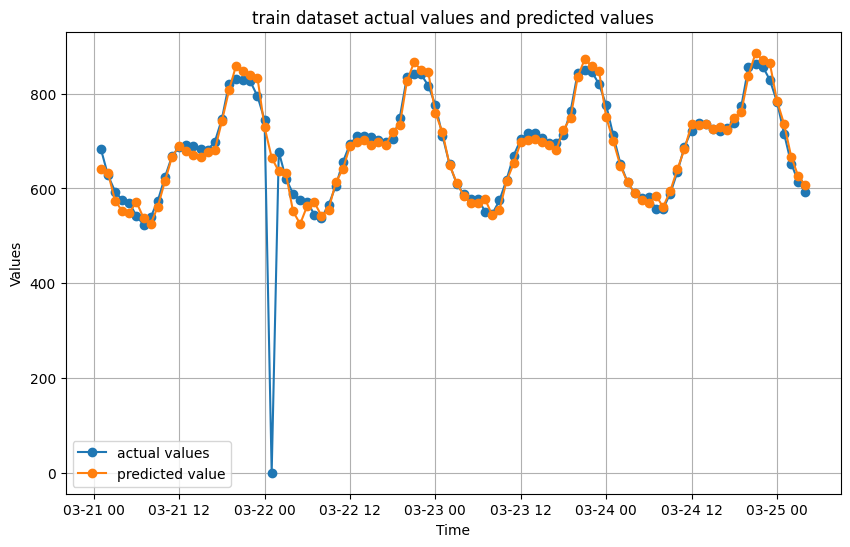

In [ ]:
# Plotting train dataset
plt.figure(figsize=(10, 6))

# Plotting actual_values against Time
plt.plot(train_plot_df['time'][:100], train_plot_df['actual_values'][:100], label='actual values', marker='o', linestyle='-')

# Plotting predictions against Time
plt.plot(train_plot_df['time'][:100], train_plot_df['predictions'][:100], label='predicted value', marker='o', linestyle='-')

plt.title('train dataset actual values and predicted values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

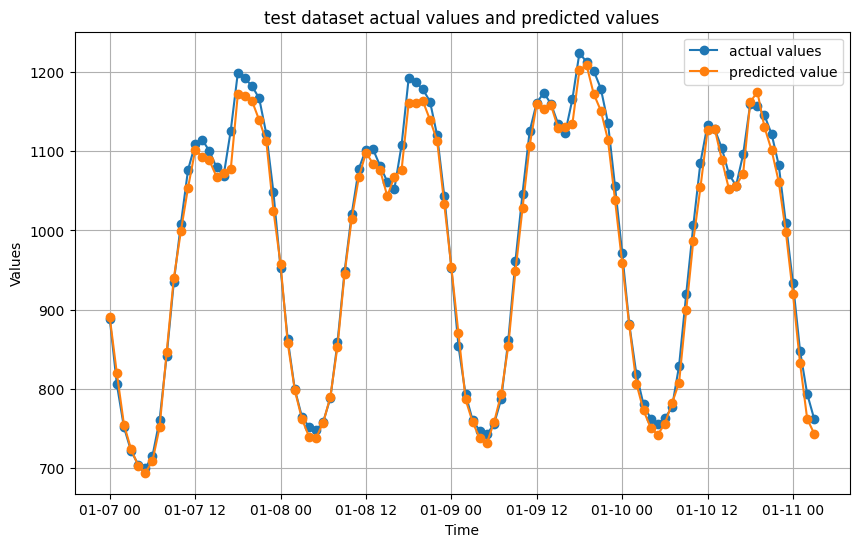

In [ ]:
# Plotting test dataset
plt.figure(figsize=(10, 6))

# Plotting actual_values against Time
plt.plot(test_plot_df['time'][:100], test_plot_df['actual_values'][:100], label='actual values', marker='o', linestyle='-')

# Plotting predictions against Time
plt.plot(test_plot_df['time'][:100], test_plot_df['predictions'][:100], label='predicted value', marker='o', linestyle='-')

plt.title('test dataset actual values and predicted values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

# LSTM model

In [120]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [133]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### data preparation

In [59]:
# Function to create windows of previous "power" values
def create_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size + 1):
        window = data.iloc[i:i+window_size].values.flatten()  # Flatten the window
        windows.append(window)
    return np.array(windows)

In [62]:
modified_concat_df = concat_df.drop(['four_mean','one_hour_ago', 'two_hours_ago', 'three_hours_ago','time'],axis =1)

### using create_windows() to create a new dataset

In [110]:
# Data preparation
window_size = 5  # Adjust as needed
lstm_input_nparray = create_windows(modified_concat_df, window_size)

lstm_output_nparray = concat_df["power"][window_size:].values
lstm_output_nparray = np.append(lstm_output_nparray, lstm_output_nparray[-1])

print(f"shape of the input: {lstm_input_nparray.shape}\nshape of the output: {lstm_output_nparray.shape}")

shape of the input: (17515, 80)
shape of the output: (17515,)


### Convert the processed data to PyTorch tensors

In [121]:
X = torch.tensor(lstm_input_nparray, dtype=torch.float32)
y = torch.tensor(lstm_output_nparray, dtype=torch.float32).view(-1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Convert data to PyTorch DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

### constructing the model

In [122]:
# Custom LSTM implementation
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

### building the train and the evaluation loop function

In [130]:
# Function to train and evaluate the model
def train_and_evaluate(model, train_loader, test_data, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):

        ### Training
        train_loss = 0
        for inputs, labels in train_loader:

            model.train()

            outputs = model(inputs.to(device))

            loss = criterion(outputs, labels.view(-1, 1).to(device))
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        # Divide total train loss by length of train dataloader (average loss per batch per epoch)
        train_loss /= len(train_loader)

        # Evaluate the model on the test set
        model.eval()
        with torch.inference_mode():
            test_inputs, test_labels = test_data
            predictions = model(test_inputs.to(device))
            test_loss = criterion(predictions, test_labels.to(device).view(-1, 1))

        ## Print out what's happening
        if (epoch+1) % 10 == 0:
            print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Epoch: {epoch+1}")

    return torch.sqrt(test_loss)

### Hyperparameter tuning using grid search

In [131]:
param_grid = {
    'num_layers': [1, 2, 3],
    'hidden_size': [32, 64, 128],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.0, 0.2, 0.4]
}


In [134]:
# for loop to search the parameter space for the best parameters
best_rmse = float('inf')
best_params = None

# Convert test data to PyTorch tensor
test_data = (X_test.to(device), y_test.to(device))

counter = 1

for params in ParameterGrid(param_grid):

    # Initialize model
    model = LSTMRegressor(
        input_size= window_size*len(modified_concat_df.columns), # Adjust input size for the number of features
        hidden_size=params['hidden_size'],
        num_layers=params['num_layers'],
        output_size=1,  # Output size for regression
        dropout_rate=params['dropout_rate']
    )

    # Choose an appropriate loss function (e.g., Mean Squared Error)
    criterion = nn.MSELoss()
    # Choose an optimizer (e.g., Adam)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

    rmse_loss = train_and_evaluate(model, train_loader, test_data, criterion, optimizer, num_epochs = 5)

    if rmse_loss < best_rmse:
        best_model = model
        best_params = params
        best_learning_rate = learning_rate
    counter +=1

print("Best Hyperparameters:", best_params)
print("Best Learning Rate:", best_learning_rate)

IndexError: ignored

In [ ]:
for params in ParameterGrid(param_grid):
    # Initialize model
    model = LSTMRegressor(
        input_size= window_size*len(modified_concat_df.columns), # Adjust input size for the number of features
        hidden_size=params['hidden_size'],
        num_layers=params['num_layers'],
        output_size=1,  # Output size for regression
        dropout_rate=params['dropout_rate']
    )

    # Choose an appropriate loss function (e.g., Mean Squared Error)
    criterion = nn.MSELoss()

    # Choose an optimizer (e.g., Adam)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

    # Train your model using DataLoader
    num_epochs = 50  # Adjust as needed
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = torch.sqrt(criterion(outputs, batch_y))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate your model on the test set
    model.eval()
    with torch.inference_mode():
        test_predictions = []
        for test_X_batch, _ in DataLoader(dataset=test_dataset, batch_size=64):
            predictions_batch = model(test_X_batch)
            test_predictions.extend(predictions_batch.numpy())

        rmse = sqrt(mean_squared_error(np.array(test_predictions), test_dataset.dataset.tensors[1].numpy()))

    # Update best parameters if the current model is better
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print("Best Hyperparameters:", best_params)
print("Best RMSE:", best_rmse)

In [ ]:
# Function to train and evaluate the model
def train_and_evaluate(model, train_loader, test_data, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):

        ### Training
        train_loss = 0
        for inputs, labels in train_loader:

            model.train()

            outputs = model(inputs.to(device))

            loss = criterion(outputs, labels.view(-1, 1).to(device))
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        # Divide total train loss by length of train dataloader (average loss per batch per epoch)
        train_loss /= len(train_loader)

        # Evaluate the model on the test set
        model.eval()
        with torch.inference_mode():
            test_inputs, test_labels = test_data
            predictions = model(test_inputs.to(device))
            test_loss = criterion(predictions, test_labels.to(device).view(-1, 1))

        ## Print out what's happening
        if (epoch+1) % 10 == 0:
            print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Epoch: {epoch+1}")


   #return train_loss , test_loss

In [ ]:
# for loop to search the parameter space for the best parameters
# Convert test data to PyTorch tensor
test_data = (X_test.to(device), y_test.to(device))
counter = 1
for params in ParameterGrid(param_grid):

    print(f"{counter} set of params in total {len(ParameterGrid(param_grid))}")
    learning_rate = params['learning_rate']
    del params['learning_rate']  # Remove learning_rate from params

    model = NeuralNetwork(input_size=X.shape[1], **params).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_and_evaluate(model, train_loader, test_data, criterion, optimizer, num_epochs = 5)

    # Evaluate the model on the test set and update the best model if needed
    model.eval()
    with torch.inference_mode():
        predictions = model(X_test.to(device))
        test_loss = mean_squared_error(predictions.numpy(), y_test.numpy())
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model
            best_params = params
            best_learning_rate = learning_rate
    counter +=1

print("Best Hyperparameters:", best_params)
print("Best Test Loss:", best_loss)
print("Best Learning Rate:", best_learning_rate)